## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: Tues 27 Nov 2018 5pm
* Instructor name: Jeff Herman
* Blog post URL:


# King County Housing Data Analysis

Using data describing conditions, sizes, locations, &c., of houses in King County, can we build a model to optimize the price of a house?

In [1]:
import pandas as pd             #for working with data as a DataFrame object
import matplotlib.pyplot as plt #for plotting simple visualizations
from scipy import stats
import numpy as np              #for math operations like log
import seaborn as sns           #for plotting advanced visualizations
import random                   #for generating random numbers for train/test split

#for dividing data into a training set and a testing set
from sklearn.model_selection import train_test_split 

#for fitting the model to training and testing data
from sklearn.linear_model import LinearRegression

#for calculating MSE of residuals
#(squares each error to remove cancelling-out effect of negative errors, 
#then finds mean of them all)
from sklearn.metrics import mean_squared_error

#for selecting the most important features in a model
from sklearn.feature_selection import RFE

#for running regression models with Ordinary Least Squares
import statsmodels.formula.api as smf

In [2]:
df_raw = pd.read_csv('kc_house_data.csv') #Import data as a Pandas DataFrame

In [3]:
#To read house prices as $ amounts instead of in scientific notation
pd.set_option('display.float_format', '{:.2f}'.format) 

In [4]:
#Function to draw in-line histograms
def inlinehists(xs, data, bins):
    fig, axs = plt.subplots(1, len(xs), sharey=False, figsize=((5 * len(xs), 4)))
    for i, x in enumerate(xs):
        data[x].hist(ax=axs[i], label=x, xlabelsize=5, bins=bins)
        axs[i].legend()
    plt.show()

In [125]:
#Function to draw a heat map to show collinearity among features.
#Uses seaborn's "corr" object and "mask" and "cmap"
def draw_heat_map(df):
    sns.set(style="white")
    corr = df.corr() # Create a covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool) #a mask the size of the matrix
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(10, 8)) # Set up the matplotlib figure
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #custom diverging colormap
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, #Draw the heatmap
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
#Function to use scikitlearn's RFE to select features.
#Returns 3 measures to be captured by new variables
def select_features(df, target_col, num_of_feats):
    features = df.drop([target_col], axis=1)
    target = df[target_col]
    X = features
    y = target
    linreg = LinearRegression() #Instantiate a new linreg object
    #Instantiate a selector object to choose features
    selector = RFE(linreg, n_features_to_select = num_of_feats) 
    selector = selector.fit(X, y)
    selector.support_ #Returns an array of bools with selected features "True"
    #Take only those columns from X that were chosen by the selector
    selected_columns = X.columns[selector.support_ ]
    #Fit the selected columns to another model
    linreg.fit(X[selected_columns],y)
    intercept = linreg.intercept_
    r_squared = linreg.score(X[selected_columns], y)
    
    return selector.support_, intercept, r_squared

In [108]:
#Function to write the 'formula' for statsmodel's Ordinary least Squares function
#and to call that function on provided data.
#Returns the model
def build_ols_model(x, y, data, target):

    columns = "+".join(x)
    formula = target + ' ~'+ columns
    model = smf.ols(formula = formula, data = data).fit()
    return model

In [103]:
#Function to generate r-squared scores for data over a range of train/test splits.
#Draws a plot to show range of errors across range of splits
def plot_tt_splits(features, target):

    random.seed(9) #to distribute data into train/test sets randomly
    X = features
    y = target
    training_error = [] #list of mean training errors, to be plotted
    testing_error = [] #list of mean testing errors, to be plotted
    sizes = list(range(5,80,5))
    
    for size in sizes:
        training_error_iter = [] #from which to take mean of training errors
        testing_error_iter = [] #from which to take mean of testing errors
        
        #generate errors 50 times, then take the mean to be plotted
        for i in range(50):
            
            #split the data proportionally using a "size" from "sizes"
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(size/100))
            #fit the training data to a model
            linreg.fit(X_train, y_train)
            #generate predicted y values (a line) from the training x variables
            y_hat_train = linreg.predict(X_train)
            #generate predicted y values (a line) from the testing x variables
            y_hat_test = linreg.predict(X_test)
            #training_error_iter.append(mean_squared_error(y_train, y_hat_train))
            #add r-squared score for training data to list from which to take mean
            training_error_iter.append(linreg.score(X_train, y_train))
            #testing_error_iter.append(mean_squared_error(y_test, y_hat_test))
            testing_error_iter.append(linreg.score(X_test, y_test))
            #(exit for loop)
        
        #add the mean of the training errors to the list to be plotted
        training_error.append(np.mean(training_error_iter)) 
        #add the mean of the testing errors to the list to be plotted
        testing_error.append(np.mean(testing_error_iter))
        #(exit for loop)
    
    plt.scatter(sizes, training_error, label='Mean training errors')
    plt.scatter(sizes, testing_error, label='Mean testing errors')
    plt.title('Comparison of mean test/train errors after 5/95 to 95/5 split')
    plt.legend()

In [ ]:
#"Get Ys and Y-hats": Function to fit a linear regression model with sklearn
#linreg object. Returns y values and predicted y values from test/train split
#def get_ys_yhats(X, y, size)
    #Use sklearn train_test_split to set aside some data for training
#    X_train, X_test, y_train, y_test = train_test_split(X, y, size=size/100)
    #Fit the training part of the data to the model
#    linreg.fit(X_train, y_train)
    #
#    y_hat_train = linreg.predict(X_train)
#    y_hat_test = linreg.predict(X_test)
#    return y_train, y_test, y_hat_train, y_hat_test    

## A first look at the raw data

In [ ]:
df_raw.info()

In [ ]:
df_raw.describe()

**Observations of data summary**

Columns to drop: ID and date (not useful here); lat and long (would be useful, but they're outside the scope of this exploration.)

Categorical columns to transform later: waterfront, view, condition, grade, zip code.

Null values to fill: waterfront, view, yr_renovated.

Price column initially displayed in scientific notation. Suppressed this globally so that prices can be understood as $ amounts.

The max value for bedrooms is preposterous and that row will probably need to be dropped if the rest of the data in the row doesn't describe a 33-bedroom house. Dropping it might also improve the distribution of other columns.

sqft_basement should be in integers to match sqft_above.

**Observations of histograms of each feature**



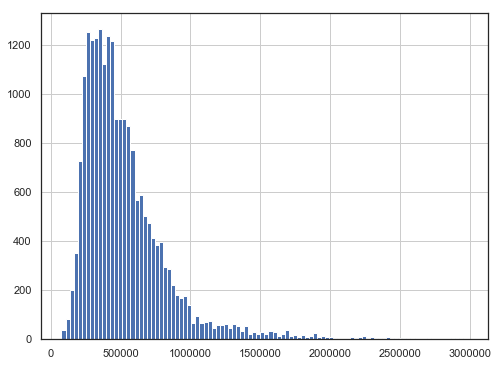

In [99]:
df_raw['price'].hist(bins=100, figsize=(8,6))

**price**: Will serve as the target, i.e. 'y', the dependent variable. We'll examine how other features effect the price of a house. A few extreme outliers on the positive side are skewing the data. (Extravagant mansions worth over 3 or 4 million dollars.) Might help to drop them.

In [ ]:
inlinehists(['bedrooms', 'bathrooms'], df_raw, 40)

**bedrooms**: Positively-skewed by a few many-bedroomed houses.

**bathrooms**: Looks not too far from a normal distribution, can probably be smoothed out. Some positive skew.

In [ ]:
inlinehists(['floors', 'condition', 'grade'], df_raw, 20)
inlinehists(['view', 'waterfront'], df_raw, 10)

**floors**: Looks categorical but would remain useful as a numerical feature for its mean, &c. Densely-distributed around the 1-floor and 2-floor values. This makes sense as a house with with fewer than 1 floor wouldn't fit humans.

**condition**: Categorical; not too abnormally-distributed. Makes sense that most houses would be in a medium condition.

**Grade**: Categorical; very normally-distributed. Similar to condition, most houses have a "medium" grade which makes sense. The tails of the distribution will be rundown houses and fancy houses.

**view**: A categorical feature with most houses having a "0" view. Makes sense intuitively that the this data wouldn't be normally distributed: the majority of houses wouldn't have even a "medium"-grade view. They'd have no interesting view at all, just a view of other houses in their neighborhood.

**waterfront**: A categorical feature, "yes" or "no", with the vast majority of houses not being on the waterfront. Makes sense. Might be the case that dropping the extravagant mansion rows will remove most of the "yes" waterfront houses, meaning this column will need to be dropped.

In [ ]:
inlinehists(['sqft_above', 'sqft_living', 'sqft_living15'], df_raw, 40)
inlinehists(['sqft_lot', 'sqft_lot15'], df_raw, 20)

**sqft_above**: Close to a normal distribution wiht some outliers positively skewing the data.

**sqft_living**: Similar shape to sqft_above, outliers positively skewing the data.

**sqft_living15**: Even more normal than sqft_living. Probably contains fewer meaningful values.

**sqft_lot**: A few extreme outliers are positively skewing the data. Might be the same extravagant mansions.

**sqft_lot15**: Similar issue to sqft_lot. A few extreme outliers are positively skewing the data.

In [ ]:
inlinehists(['yr_built', 'yr_renovated'], df_raw, 40)

**yr_built**: Negative skew towards earlier years. A spurt of new construction in the very recent past. Not sure whether to expect a normal distribution of this feature if we assume that the population of the city increases steadily from decade to decade; the bulk of the housing stock would already exist and wouldn't be replaced, but some new residents would move into new construction neighborhoods.

**yr_renovated**: If only describing renovations after 2015, then it's a categorical column.

## Cleaning the raw data

**Resetting the index**

In [6]:
df_raw = df_raw.reset_index(drop=True) #Prevents dropped rows from throwing errors later

**Dropping irrelevant columns**

In [7]:
df_raw = df_raw.drop(['id', 'date', 'lat', 'long'], axis=1) #Drop the id and date columns

**Dropping the 33-bedroom house**

Let's check if there are any other over-bedroomed houses.

In [ ]:
df_raw['bedrooms'].value_counts() #Check for other houses with a lot of bedrooms

The 10- and 11-bedroom houses also look suspicious.

In [ ]:
beds_10 = df_raw[df_raw['bedrooms'] >= 10]  
beds_10

The only house whose specs look plausible is row 13301. (5 bathrooms, price over 1 mil.) Going to drop the others.

In [8]:
df_raw = df_raw.drop([8748, 15147, 15856, 19239]) # Drop the rows with 10-or-more-bed houses

**Dropping the extravagant mansions**

Positive skew in the histogram of the price column suggests that a few extremely-high-value houses could be dropped.

In [ ]:
print('99% of houses have a price under', df_raw['price'].quantile(.99)) #Return 99th percentile

In [ ]:
over2mil = df_raw[df_raw['price'] > 2000000]
over3mil = df_raw[df_raw['price'] > 3000000]
over4mil = df_raw[df_raw['price'] > 4000000]

print('House prices over 2 mil: ', over2mil.shape[0])
print('House prices over 3 mil: ', over3mil.shape[0])
print('House prices over 4 mil: ', over4mil.shape[0])

Let's drop the outliers over 3 million to reduce the positive skew of the price feature.

In [9]:
df_raw = df_raw[df_raw['price'] < 3000000] #Drop rows with price over 3 mil

**Filling in null values for waterfront**

How many null values?

In [10]:
#Every null value is returned as False; add up the Falses for total of nulls
print(df_raw['waterfront'].isna().sum(), 'null values in waterfront column') 

2375 null values in waterfront column


It's safe to assume these 2376 houses do not front the water. Let's fill them with 0. Later they'll be converted to a categorical value.

In [11]:
df_raw['waterfront'] = df_raw['waterfront'].fillna(0) #Fill null values with 0, i.e. "Is waterfront = False"

**Filling in null values for view**

How many null values are there, and which other value is the most reasonable to fill them with?

In [12]:
print(df_raw['view'].value_counts()) #Returns the sum of the observations of each value in the column
print('\n')
print('Total nulls in view: ', df_raw['view'].isna().sum())

0.00    19403
2.00      953
3.00      506
1.00      328
4.00      290
Name: view, dtype: int64


Total nulls in view:  62


Most houses have a "0" view. That's a pity. We can assume the 62 nulls also have a "0" view.

In [13]:
df_raw['view'] = df_raw['view'].fillna(0)

**Filling in null values for yr_renovated**

How many rows have a yr_renovated value that isn't 0 or null?

In [14]:
yr_rn_total = df_raw.shape[0] #Total number of rows in yr_renovated
yr_rn_zeros = df_raw[df_raw['yr_renovated'] == 0.00].shape[0] #Number of 0 values in yr_renovated
yr_rn_nulls = df_raw['yr_renovated'].isna().sum() #Number of nulls in yr_renovated

print('Rows in yr_renovated: ', yr_rn_total)
print('Zero values: ', yr_rn_zeros)
print('Null values: ', yr_rn_nulls)
print('Non-zero, non-null values: ', (yr_rn_total - yr_rn_zeros - yr_rn_nulls))

Rows in yr_renovated:  21542
Zero values:  16972
Null values:  3835
Non-zero, non-null values:  735


Not enough values for the column to be useful. Let's drop it.

In [15]:
#Save yr_renovated for later, just in case
yr_renovated = df_raw['yr_renovated']

In [16]:
df_raw = df_raw.drop(['yr_renovated'], axis=1) #Drop the yr_renovated column

**Converting sqft_basement to integers**

In [17]:
df_raw['sqft_basement'].head(7)

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [ ]:
type(df_raw['sqft_basement'][1]) #Looks like the float 400.0 but is actually the str'400.0'

This column is riddled with '?'s and values that look numerical but are actually strings. Let's replace '?' with 0, and convert the fake number strings into floats, and then into integers.

In [18]:
df_raw['sqft_basement'] = df_raw['sqft_basement'].replace('?', 0)
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('float') #Must convert strings to floats first
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('int') #Then convert the floats to integers

## A second look

In [ ]:
#IN PROGRESS

In [ ]:
df_raw['price'].hist(bins=100)

In [ ]:
columns_for_hist = ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'price', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15']

plt.figure(figsize=(10,10))
plt.scatter(df_raw['bedrooms'], df_raw['price'])
plt.show()

### Checking for multicollinearity

Let's use a heatmap to check if any features follow the same curve as any others. Collinearity could reduce the accuracy of our model later on.

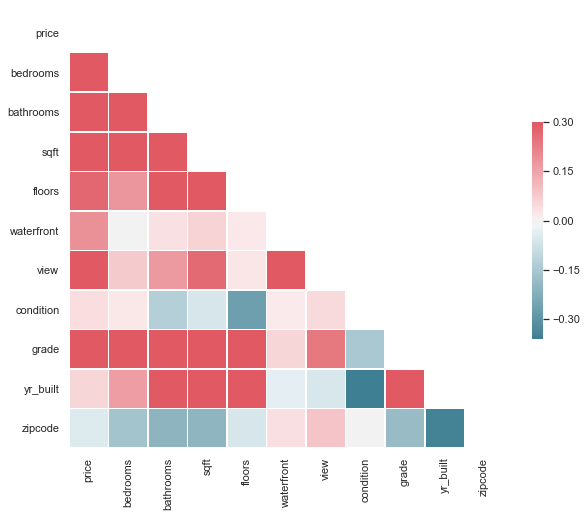

In [93]:
draw_heat_map(df_raw)

Yikes. There is a lot of collinearity across columns. But we probably don't need 6 different measures of square footage. Let's pick 1 or 2.

In [ ]:
#Plot the first 4 measures of sqft on top of each other to compare
plt.figure(figsize=(8, 6))
plt.scatter(df_raw['sqft_living'], df_raw['price'], label='sqft_living')
plt.scatter(df_raw['sqft_above'], df_raw['price'], label='sqft_above')
plt.scatter(df_raw['sqft_basement'], df_raw['price'], label='sqft_basement')
plt.scatter(df_raw['sqft_living15'], df_raw['price'], label='sqft_living15')
plt.title('Price by measures of house square footage')
plt.legend()

A lot of overlap among all 4. Let's keep sqft_living and drop the rest.

In [ ]:
#Plot the other 2 measures of sqft to compare
plt.figure(figsize=(8, 6))
plt.scatter(df_raw['sqft_lot'], df_raw['price'], label='sqft_lot')
plt.scatter(df_raw['sqft_lot15'], df_raw['price'], label='sqft_lot15')
plt.title('Price by measures of lot square footage')
plt.legend()

Neither of these looks very helpful. Not only do they overlap each other quite closely, but the upward thrust close to x=0 suggests that smaller lots are priced across the full range of price values. In other words, you can probably maximize the value of your house even if your lot is small.

In [19]:
df_raw = df_raw.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 
                      'sqft_lot', 'sqft_lot15'], axis=1) #Drop multicollinear columns
df_raw = df_raw.rename(index=str, columns={'sqft_living': 'sqft'})

## Questions

1. How strong is the relationship between price on the one hand and view and waterfront on the other? These features of a house are outside the control of the homeowner. If the relationship is weak, we may be able to encourage homeowners that they can maximize their house's value with features under their control.

2. Should you improve the condition of your house before you try to sell it, or is it possible to get a high price on a ramshackle house on the merits of its other features, e.g. its location?

3. Do certain zip codes have more high-value houses than others? If so, a good way to increase the value of one's home may be to make civic improvements in the larger neighborhood.

In [ ]:
#sns.pairplot(df_raw, x_vars=[df_raw['view'], df_raw['waterfront']], y_vars=df_raw['price'], kind='reg', height=(10))

## Feature scaling of continuous variables

In [22]:
df_normed = df_raw.copy() # A deep copy of the raw data to normalize

**Box-Cox transformation (TEST)**

In [ ]:
#BoxCox experiment

#plt.hist(df_raw['sqft_living'], bins=50)

In [ ]:
#transform = np.asarray(df_raw[['sqft_living']].values)

In [ ]:
#dft = stats.boxcox(transform)[0]

In [ ]:
#plt.hist(dft, bins=50)
#plt.show()

**Log-transforming of continuous variables**

In [23]:
#First log-transform each column to reduce skew
#and set a similar scale for each
price_normed = np.log(df_normed['price'])
sqft_normed = np.log(df_normed['sqft']) 
yr_built_normed = np.log(df_normed['yr_built'])

**Scaling continuous variables**

In [24]:
#Use min-max scaling to reduce effect of outliers
price_normed = (price_normed - min(price_normed)) / (max(price_normed) - min(price_normed))

#Standardize to take z-scores
sqft_normed = (sqft_normed - sqft_normed.mean()) / sqft_normed.std()
yr_built_normed = (yr_built_normed - yr_built_normed.mean()) / yr_built_normed.std()

In [25]:
#Replace the columns with the normalized data
df_normed['price'] = price_normed
df_normed['sqft'] = sqft_normed
df_normed['yr_built'] = yr_built_normed

## Converting categorical variables

In [26]:
df_cat = df_normed.copy() #Normalized data, ready for categorizing

In [27]:
#Convert data to dtype 'category'
df_cat['waterfront'] = df_cat['waterfront'].astype('bool').astype('category')
df_cat['view'] = df_cat['view'].astype('int').astype('category')
df_cat['condition'] = df_cat['condition'].astype('int').astype('category')
df_cat['grade'] = df_cat['grade'].astype('int').astype('category')
df_cat['zipcode'] = df_cat['zipcode'].astype('category')

In [28]:
#Create a new set of columns for each category
water_dummies = pd.get_dummies(df_cat['waterfront'], prefix='water')
view_dummies = pd.get_dummies(df_cat['view'], prefix='view')
condit_dummies = pd.get_dummies(df_cat['condition'], prefix='condit')
grade_dummies = pd.get_dummies(df_cat['grade'], prefix='grade')
zip_dummies = pd.get_dummies(df_cat['zipcode'], prefix='zip')

In [29]:
#Drop original columns
df_cat = df_cat.drop(['waterfront', 'view', 'condition', 'grade', 'zipcode'], axis=1)
#Add the new columns
df_cat = pd.concat([df_cat, water_dummies, view_dummies, condit_dummies, grade_dummies, zip_dummies], axis=1)


In [30]:
print(f"df_cat now has {df_cat.shape[1]} columns")

df_cat now has 99 columns


Now let's drop the last column of each category. (Values not contained in any other column in the set of dummies will by default by contained in the last column, so we can assume they are there and drop it.)

In [31]:
df_cat = df_cat.drop(['water_True', 'view_4', 
                      'condit_5', 'grade_13', 'zip_98199'], axis=1)
print(f"df_cat now has {df_cat.shape[1]} columns")

df_cat now has 94 columns


## Modeling

In [63]:
df = df_cat.copy() #Final version of data, ready for modeling

What about the number of bedrooms, bathrooms, and floors? Could sqft serve as a proxy for these?

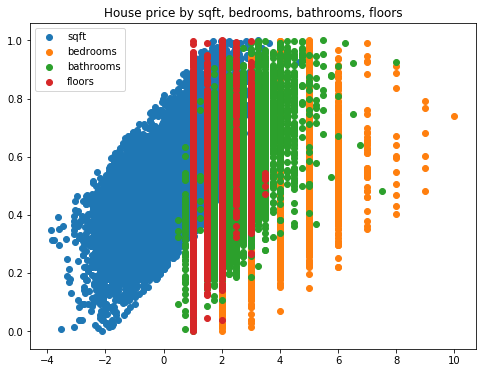

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(df['sqft'], df['price'], label='sqft')
plt.scatter(df['bedrooms'], df['price'], label='bedrooms')
plt.scatter(df['bathrooms'], df['price'], label='bathrooms')
plt.scatter(df['floors'], df['price'], label='floors')
plt.title('House price by sqft, bedrooms, bathrooms, floors')
plt.legend()
plt.show()

Strong collinearity among sqft, bedrooms, and bathrooms. It looks like sqft will have the clearest linear relationship with price, so let's use it in comparisons with the other features. It can be taken as a good proxy for the overall area of a house's rooms and floors.

In [64]:
df = df.drop(['bedrooms', 'bathrooms', 'floors'], axis=1)

In [ ]:
df.head()

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


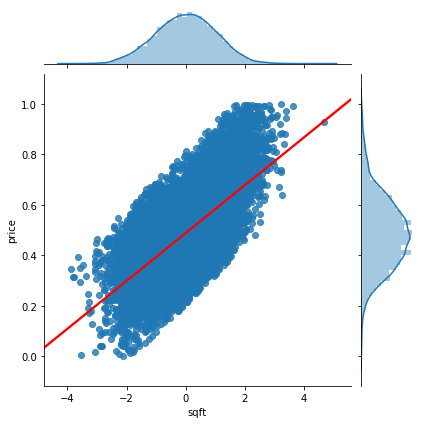

In [35]:
#Sqft has an almost-perfectly linear relationship with price

sns.jointplot(x='sqft', y='price', data=df, kind='reg', 
                  label='sqft', joint_kws={'line_kws':{'color':'red'}})

## The first model

In [43]:
#DELETE IF NOT USED LATER
#Calculate residuals (errors between predicted y values and actual y values)
#train_residuals = y_hat_train - y_train
#test_residuals = y_hat_test - y_test

In [42]:
features = df.drop(['price'], axis=1)
target = df['price']
X = features
y = target

#Divide the data in X and y into proportionate sets for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.3))

linreg = LinearRegression() #Initialize a model
linreg.fit(X_train, y_train) #Fit the training data to the model

#Calculate predicted y (price) values on the training set of x (features)
y_hat_train = linreg.predict(X_train)
#Calculate predicted y (price) values on the testing set of x (features)
y_hat_test = linreg.predict(X_test)

#Crunch the MSE for training data and testing data
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('MSE for training data:', train_mse)
print('MSE for testing data:', test_mse)
print('Intercept:', linreg.intercept_)
print('R^2 score:', linreg.score(X, y))

MSE for training data: 0.00263975984685568
MSE for testing data: 0.002677814722061532
Intercept: 1.0258862813724747
R^2 score: 0.8685256484385432


First model shows very low errors and a very high R-squared score, indicating the model fits the data very well. Doesn't seem like a probable result for a first model, so I'll try some others. My working theory is that sqft is so perfectly-correlated to price that it conceals the relationship between price and the other factors. 

## Iterative feature selection for first model

In [47]:
num_of_cols = len(df.drop(['price'], axis=1).columns)
#keep track of how many times each column is chosen
selected_columns = np.zeros(shape = num_of_cols) 
intercepts = []
r_squareds = []
#iterate over the full range of features in the df
for i in range(1, (num_of_cols + 1)):
    selected, intercept, r_squared = select_features(df, 'price', i)
    selected_columns += selected.astype('int') # add these to the total
    intercepts.append(intercept) #add intercept to the total
    r_squareds.append(r_squared) #add r_squared to the total

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


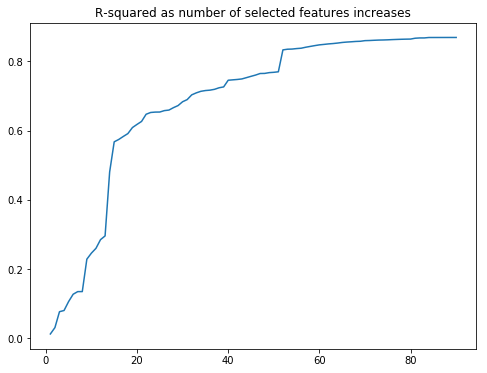

In [48]:
x = pd.DataFrame(list(range(1, (len(r_squareds) + 1))))
y = pd.DataFrame(r_squareds)
fig = plt.figure(figsize = (8,6))
plt.plot(x, y)
plt.title('R-squared as number of selected features increases')
plt.show()

R-squared approaches 0.9 out of 1.0 as number of features increases. Doesn't make dramatic jump when sqft is added as the 39th feature.

In [49]:
r_squareds[12]

0.2957569284076183

In [50]:
selected, intercept, r_squared = select_features(df, 'price', 12)
print(X.columns[selected])

Index(['water_False', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'zip_98001',
       'zip_98003', 'zip_98004', 'zip_98023', 'zip_98032', 'zip_98039',
       'zip_98112'],
      dtype='object')


In [51]:
selected, intercept, r_squared = select_features(df, 'price', 13)


In [52]:
print(X.columns[selected])

Index(['water_False', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'zip_98001',
       'zip_98003', 'zip_98004', 'zip_98023', 'zip_98032', 'zip_98039',
       'zip_98092', 'zip_98112'],
      dtype='object')


In [53]:
column_totals_unsorted = zip(X.columns, selected_columns)
column_totals = sorted(column_totals_unsorted, key=lambda tup: tup[1], reverse=True)

In [54]:
print('Sqft was selected for', column_totals[51][1], 'out of', len(df.drop(['price'], axis=1).columns), 'models')

Sqft was selected for 39.0 out of 90 models


**Iteratively generating test/train errors to find optimal test-train split**

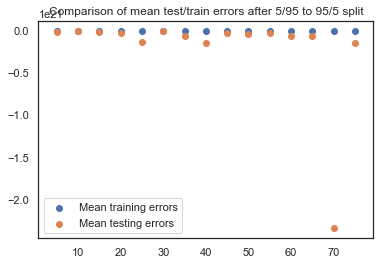

In [105]:
#FROM FIRST MODEL
plot_tt_splits(df.drop(['price'], axis=1), df['price'])

Error for training data never changes no matter the size of the training data. Suggests overfitting. This model uses 90 features including all the categorical variables. Should see what kinds of errors are generated by each categorical variable. Perhaps there is a lot of collinearity among the categorical features.

## The second model

df2 = df.copy()

In [260]:
#A model for each categorical feature: water, view, condit, grade, zip
water = df2.columns[df2.columns.str.contains(pat = 'water')]
view = df2.columns[df2.columns.str.contains(pat = 'view')]
condit = df2.columns[df2.columns.str.contains(pat = 'condit')]
grade = df2.columns[df2.columns.str.contains(pat = 'grade')]
zipcode = df2.columns[df2.columns.str.contains(pat = 'zip')]

In [261]:
water_model = build_ols_model(water, df2['price'], df2, 'price')
view_model = build_ols_model(view, df2['price'], df2, 'price')
condit_model = build_ols_model(condit, df2['price'], df2, 'price')
grade_model = build_ols_model(grade, df2['price'], df2, 'price')
zip_model = build_ols_model(zipcode, df2['price'], df2, 'price')

In [262]:
cat_models = [water_model, view_model, condit_model, grade_model, zip_model]
cats = ['water', 'view', 'condit', 'grade', 'zip']

In [263]:
for model in cat_models:
    print(model.rsquared)

0.018326629614494716
0.11184978825610026
0.013883958727505363
0.4855090620421225
0.5304038898387754


In [264]:
price_and_water = pd.concat([df2['price'], df2[water]], axis=1)
price_and_view = pd.concat([df2['price'], df2[view]], axis=1)
price_and_condit = pd.concat([df2['price'], df2[condit]], axis=1)
price_and_grade = pd.concat([df2['price'], df2[grade]], axis=1)
price_and_zipcode = pd.concat([df2['price'], df2[zipcode]], axis=1)

In [ ]:
############################### CONTINUE HERE#######################

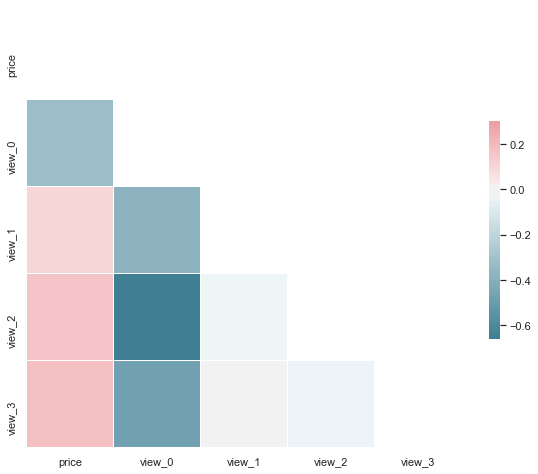

In [269]:
draw_heat_map(price_and_view)

Interesting sign of a downward relationship between price and view_0 and positve relationship between price and the other views. Might be more economical to concatonate views 1, 2, and 3 into a single column to contrast with view_0.

In [279]:
views123 = np.array(df2['view_1']) + np.array(df2['view_2']) + np.array(df2['view_3'])#, df2['view_2'], df2['view_3']], axis=1)

In [284]:
df2['view_2'].shape

(43084,)

In [282]:
pd.DataFrame(views123)

,0
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
5,0.00
6,0.00
7,0.00
8,0.00
9,0.00


In [ ]:
draw_heat_map(price_and_condit)

**Collinearity among grades**

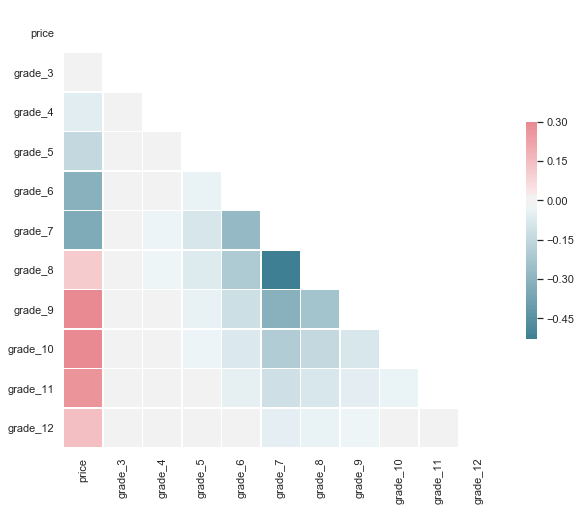

In [268]:
draw_heat_map(price_and_grade)

I'll keep all the grade columns since they appear to hvae strong relationships with price and no notable relationships with each other except for a negative collinearity between grade_7 and grade_8.

**Collinearity among zipcodes**

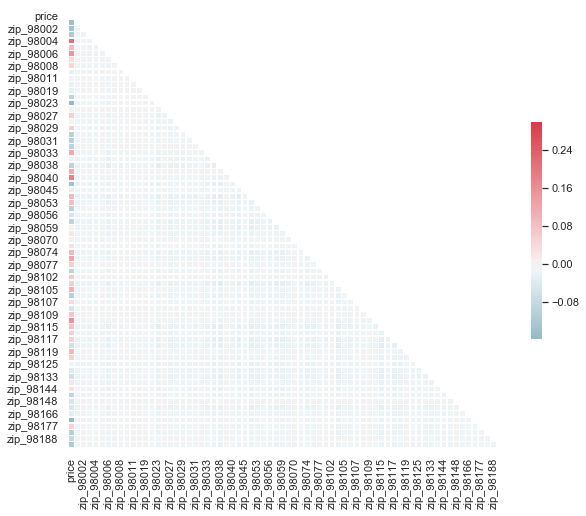

In [267]:
draw_heat_map(price_and_zipcode)

There cannot be any collinearity among zip codes because no 2 zip codes' True values share a row.

Looks like some zip codes have a strong positive or negative relationship with price while many don't. Might be useful to see them arranged in descending order by the mean house price of each zip code. Then the zip codes with the weakest relationship to price can be dropped.

**Collinearity between grade and condition**

In [257]:
grade_condit = pd.concat([df[grade], df[condit]], axis=1)

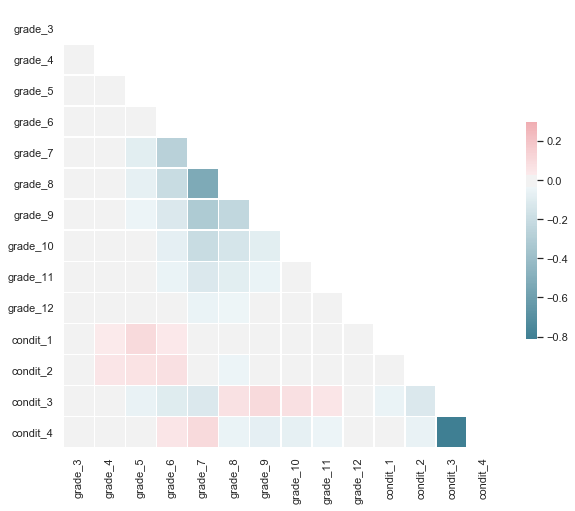

In [258]:
draw_heat_map(grade_condit)

Thought there might be some collinearity between the two but am not seeing too much.

## Zip code exploration

In [207]:
mean_prices_of_zips = []
for column in zipcode:
    #add the mean of the prices for all observations in the column
    #where the particular zipcode value is 1 (or True)
    mean_prices_of_zips.append(df['price'][df[column] == True].mean())
#dictionary to combine zipcodes with their mean prices
d = {'zipcode': zipcode, 'mean_price': mean_prices_of_zips}
#new dataframe from the dictionary
mean_prices_zips = pd.DataFrame(data=d)
#correct the dataframe for mean prices
mean_prices_zips['mean_price'] = mean_prices_zips['mean_price'].astype('float')


In [212]:
#Top 10 mean house prices by zip code
mean_prices_zips.sort_values(by=['mean_price'], ascending=False)[0:10]
#98039 Medina
#98004 Bellevue
#98040 #Mercer Island
#98112 Madison Park and Montlake in Seattle
#98109 Eastern half of Queene Anne and South Lake Union
#98005 Bellevue
#98006 South Bellevue
#98105 U District
#98119 Queene Anne
#98102 East Lake and north Broadway corridor of Capitol Hill

,zipcode,mean_price
24,zip_98039,0.84
3,zip_98004,0.74
25,zip_98040,0.72
48,zip_98112,0.69
47,zip_98109,0.63
4,zip_98005,0.63
5,zip_98006,0.63
43,zip_98105,0.63
53,zip_98119,0.63
41,zip_98102,0.62


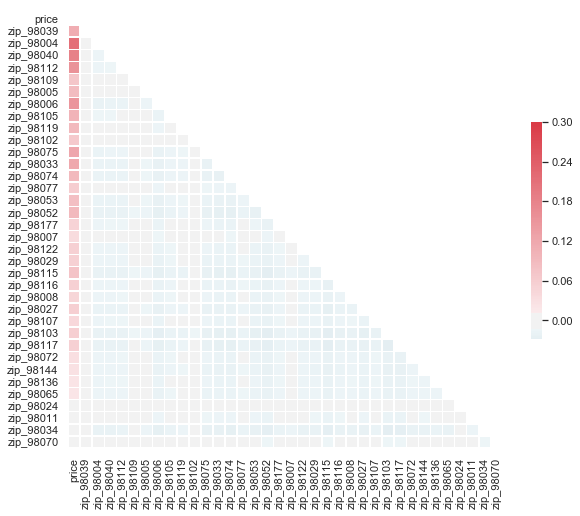

In [248]:
top_0_35_zips = pd.Index(
                mean_prices_zips.sort_values(by=['mean_price'], 
                                            ascending=False)[0:35]['zipcode'])
price_and_zip_0_35 = pd.concat([df['price'], df[top_0_35_zips]], axis=1)
draw_heat_map(price_and_zip_0_35)

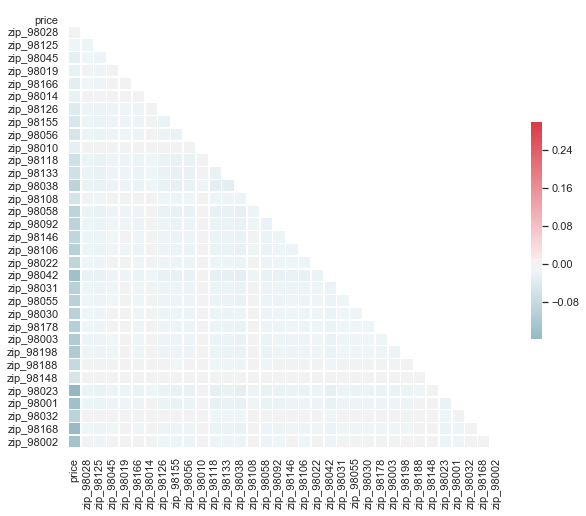

In [249]:
bot_36_70_zips = pd.Index(
                mean_prices_zips.sort_values(by=['mean_price'], 
                                            ascending=False)[36:70]['zipcode'])
price_and_zip70 = pd.concat([df['price'], df[bot_36_70_zips]], axis=1)
draw_heat_map(price_and_zip70)

Strong positive relationship between the zip codes with the highest average house prices; strong negative relationship between the zip codes with the lowest average house prices. Suggests that the "middle" of the range is just noise which might be muddling the model and adding to computation time. Going to keep the top 20 and bottom 20 and drop the middle 30.

In [ ]:
middle_30_zips = pd.Index(
                mean_prices_zips.sort_values(by=['mean_price'], 
                                            ascending=False)[20:50]['zipcode'])
 df[top_0_35_zips]]

In [73]:
df2 = df.copy()

**Iteratively generating test/train errors to find optimal test-train split**

In [ ]:
random.seed(9)

features = df.drop(['price'], axis=1)
target = df['price']
X = features
y = target

training_error = []
testing_error = []
sizes = list(range(5,80,5))
for size in sizes:
    training_error_iter = []
    testing_error_iter = []
    for i in range(80):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(size/100))
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        training_error_iter.append(mean_squared_error(y_train, y_hat_train))
        testing_error_iter.append(mean_squared_error(y_test, y_hat_test))
    training_error.append(np.mean(training_error_iter))
    testing_error.append(np.mean(testing_error_iter))
plt.scatter(sizes, training_error, label='Mean training errors')
plt.scatter(sizes, testing_error, label='Mean testing errors')
plt.title('Comparison of mean test/train errors after 80 iterations')
plt.legend()

**Iterative regression**


**ordinary least squares**
use smf.ols
build a formula to put into the function



**recursive feature elimination** 
    Import RFE from sklearn
    make a for loop to run linreg on the data with first 1 feature, then several, then several more, &c. Set up a range with numpy from 1 to the total number of features, going up by 10 or so
    will start to overfit as more features are added
    Compare r square and r square adjusted
    Values will get higher as model gets more accurate (approaching 1 from 0)
    
**train test split**
    Import train test split from sklearn
    Function takes 4 variables
    Perform linreg on the train set and the test set, then compare:
    Calculate MSEs for both train results and test results
    Value will get smaller as model gets more accurate (error gets closer to 0)


**k fold cross validation**
    Pick best features to use by calling RFE
    Call cross_val_score with linreg, X, and y, and choose  a number of folds.
    Returns an array of negative MSEs
    If there are a lot of dummy/categorical variable columns, some MSEs in the resulting array will have weird results. If so, use fewer predictors.
holdout validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

docstrings for original functions
map with longitudes/latitudes?
what is "grade" -- look at king county

good summary of linear regression in python at https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606

In [ ]:
Saving this in case it comes up again:
    df_raw.loc[0, 'sqft_basement'] = 0 #Correct way to insert a value into a df without chain indexing